In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import meld
import seaborn as sns 
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import phate
import cmocean
import scprep
import sklearn
from scipy import sparse
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re

pandas2ri.activate()

### Orthologous Genes

In [2]:
orthos=pd.read_csv("/Users/justinkaufman/Psych_196B_Research/ortho_genes.csv") # have to change directory to wherever this file is located on device

In [3]:
orthos=orthos[orthos['Mouse orthology confidence [0 low, 1 high]']==1]
orthos.dropna(inplace=True)
orthos.reset_index(drop=True, inplace=True)
orthos

,Gene stable ID,Gene name,Mouse gene name,"Mouse orthology confidence [0 low, 1 high]"
0,ENSMMUG00000000632,SH3BP5L,Sh3bp5l,1
1,ENSMMUG00000038159,OR2W3,Olfr322,1
2,ENSMMUG00000005570,TRIM58,Trim58,1
3,ENSMMUG00000006214,OR11L1,Olfr323,1
4,ENSMMUG00000022208,SCCPDH,Sccpdh,1
...,...,...,...,...
13703,ENSMMUG00000065379,ND4L,mt-Nd4l,1
13704,ENSMMUG00000065387,ND4,mt-Nd4,1
13705,ENSMMUG00000065354,ND5,mt-Nd5,1
13706,ENSMMUG00000065359,ND6,mt-Nd6,1


# Read in mouse rds object 

In [4]:
readRDS = robjects.r['readRDS']
base = importr('base')

In [5]:
mouseRGC = base.readRDS('/Users/justinkaufman/Psych_196B_Research/AdultMouseRGCObject/RGConly_MNNCluster_181111.rds')

In [6]:
print(tuple(mouseRGC.slots.keys()))

('data', 'count.data', 'regress.data', 'scale.data', 'var.genes', 'is.expr', 'ident', 'data.info', 'project.name', 'dr', 'de.list', 'de.union', 'hvg.info', 'imputed', 'cell.names', 'cluster.tree', 'adjmat', 'calc.params', 'kmeans', 'spatial', 'misc', 'clust.avg.exp', 'clust.avg.perc', 'ident.fxn', 'version', 'data.ngene', 'pca.x', 'pca.rot', 'pca.var', 'pca.obj', 'tsne.rot', 'ica.rot', 'ica.x', 'ica.obj', 'class')


In [7]:
# print(mouseRGC.slots['ident'])

In [8]:
# data_info_df=mouseRGC.slots['data.info']
# data_info_df.iloc[:,15:25]

In [9]:
mouseRGC_types=pd.read_csv("/Users/justinkaufman/Psych_196B_Research/mouseRGC_types.csv") # have to change directory to wherever this file is located on device
mouseRGC_types.rename(columns={"Unnamed: 0": "seq"},inplace=True)
mouseRGC_types

,seq,new_types
0,aRGC1_AAACCTGAGAATCTCC-1,7_Novel
1,aRGC1_AAACCTGAGCGACGTA-1,40_M1dup
2,aRGC1_AAACCTGGTAAATGAC-1,40_M1dup
3,aRGC1_AAACCTGTCAAGGCTT-1,27_Novel
4,aRGC1_AAACGGGAGCAGCGTA-1,19_Novel
...,...,...
35694,aRGC10_TTTGTCAAGGAACTGC-1,2_W3D1.2
35695,aRGC10_TTTGTCAAGTAGGTGC-1,2_W3D1.2
35696,aRGC10_TTTGTCACATGTAAGA-1,8_Novel
35697,aRGC10_TTTGTCAGTCTAGGTT-1,3_FminiON


In [10]:
mouseRGC_count=pd.read_csv("/Users/justinkaufman/Psych_196B_Research/mouseRGC_count_data.csv") # have to change directory to wherever this file is located on device
mouseRGC_count.rename(columns={'Unnamed: 0':'gene'}, inplace=True)
mouseRGC_count.reset_index()
mouseRGC_count.head()

,gene,aRGC1_AAACCTGAGAATCTCC-1,aRGC1_AAACCTGAGCGACGTA-1,aRGC1_AAACCTGGTAAATGAC-1,aRGC1_AAACCTGTCAAGGCTT-1,aRGC1_AAACGGGAGCAGCGTA-1,aRGC1_AAACGGGCAATCTACG-1,aRGC1_AAACGGGCACCACCAG-1,aRGC1_AAACGGGCAGCGTTCG-1,aRGC1_AAACGGGCAGGTTTCA-1,...,aRGC10_TTTGGTTTCCACGTGG-1,aRGC10_TTTGGTTTCCCTGACT-1,aRGC10_TTTGGTTTCTGATACG-1,aRGC10_TTTGTCAAGAGTTGGC-1,aRGC10_TTTGTCAAGCCGCCTA-1,aRGC10_TTTGTCAAGGAACTGC-1,aRGC10_TTTGTCAAGTAGGTGC-1,aRGC10_TTTGTCACATGTAAGA-1,aRGC10_TTTGTCAGTCTAGGTT-1,aRGC10_TTTGTCATCGCCTGAG-1
0,Xkr4,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Gm1992,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Gm37381,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Sox17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Gm37323,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# filter1 = mouseRGC_count['gene'].isin(list(orthos['Mouse gene name']))
# filter2 = mouseRGC_count['gene'].isin(list(orthos['gene name']))
#mosueRGC_count[filter1 & filter2]

In [12]:
mouseRGC_count=mouseRGC_count.loc[mouseRGC_count['gene'].isin(list(orthos['Mouse gene name']))]

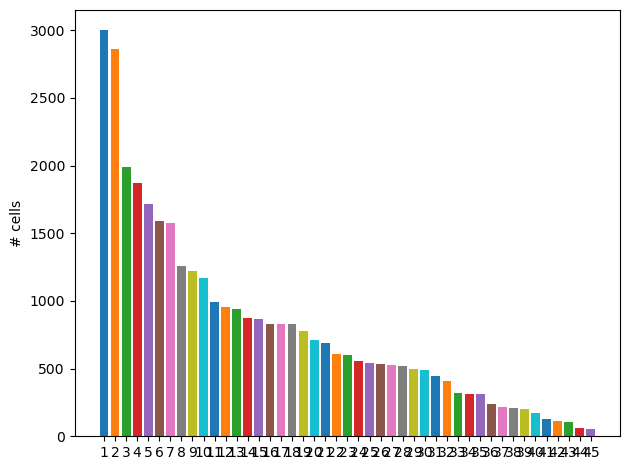

In [13]:
fig, ax = plt.subplots(1)

groups, counts = np.unique(mouseRGC.slots['ident'], return_counts=True)
for i, c in enumerate(counts):
    ax.bar(i, c)
    
ax.set_xticks(np.arange(i+1))
ax.set_xticklabels(groups)
ax.set_ylabel('# cells')

fig.tight_layout()

In [14]:
pca_mouseRGC=mouseRGC.slots['pca.rot']
pca_mouseRGC

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90
aRGC1_AAACCTGAGAATCTCC-1,8.745944,-6.359495,-16.309794,-4.476088,5.072967,1.785804,1.328692,1.566450,6.864920,-4.215419,...,0.831761,-0.037156,-0.719418,-1.161204,0.308965,1.414349,-1.117919,-0.009773,-0.648225,0.650648
aRGC1_AAACCTGAGCGACGTA-1,8.494786,-11.739689,-22.955446,-5.026223,-1.064189,-18.592966,-9.243078,-11.756335,-3.717904,19.067586,...,0.410240,-0.154669,-6.952888,2.227747,1.988378,-4.360306,-5.757059,4.316512,1.596782,-1.922258
aRGC1_AAACCTGGTAAATGAC-1,2.961551,-9.965038,-21.104850,-3.577947,-4.526950,-16.601243,-6.743233,-10.076475,-4.453045,17.549366,...,2.200324,2.809421,0.738358,-1.986100,-2.620955,-0.550103,1.077975,1.009577,-2.574030,1.893105
aRGC1_AAACCTGTCAAGGCTT-1,23.523083,-0.038509,-1.664531,7.299012,0.781786,-4.761108,1.671381,1.223286,-8.402879,-4.073430,...,0.262574,0.584572,-0.533935,0.649383,0.780616,0.473075,-1.413916,-0.862039,0.151566,-0.898702
aRGC1_AAACGGGAGCAGCGTA-1,2.896740,6.946160,-3.952736,0.505050,-3.055906,-3.810918,-0.308481,0.890120,1.142434,4.191656,...,-0.849359,-1.394044,-0.527050,-0.871624,1.672103,0.323732,1.629349,0.174215,-1.075537,0.018037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aRGC10_TTTGTCAAGGAACTGC-1,-11.463398,-1.595074,2.215939,4.300924,3.103959,-0.490052,3.057418,0.094010,-1.473914,0.320497,...,-0.428348,0.897826,-0.793916,0.534405,-0.683703,-0.225544,-0.288724,0.771879,0.797061,-0.193930
aRGC10_TTTGTCAAGTAGGTGC-1,-11.724400,0.126526,1.466790,4.111805,4.274927,-1.583116,3.792938,1.207834,-3.084974,0.374749,...,0.497393,0.709737,0.757775,0.911986,-0.593866,-0.221823,-1.166072,0.416831,-2.185121,-0.888949
aRGC10_TTTGTCACATGTAAGA-1,-0.892419,-10.564849,-0.360116,1.677696,4.023901,0.356746,4.747637,-1.116791,-0.419076,-0.557992,...,-0.596371,1.290011,0.296436,0.598117,-1.490578,-0.667912,1.042985,-1.025638,-0.533602,1.302810
aRGC10_TTTGTCAGTCTAGGTT-1,-10.850538,-1.151213,2.902091,1.055440,3.469950,0.469451,-0.262141,2.518036,1.559788,2.800992,...,0.779181,-0.948467,-1.524267,0.311231,-0.208558,-0.449889,-1.828528,-0.181265,-0.014831,-0.441798


In [15]:
phate_op = phate.PHATE(n_jobs=-1)
data_phate = phate_op.fit_transform(pca_mouseRGC)

Calculating PHATE...
  Running PHATE on 35699 observations and 90 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 52.61 seconds.
    Calculating affinities...
    Calculated affinities in 2.69 seconds.
  Calculated graph and diffusion operator in 55.35 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.69 seconds.
    Calculating KMeans...
    Calculated KMeans in 8.03 seconds.
  Calculated landmark operator in 11.53 seconds.
  Calculating optimal t...
    Automatically selected t = 54
  Calculated optimal t in 5.56 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.05 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.48 seconds.
Calculated PHATE in 76.01 seconds.


### Phate plot by ident label

/opt/miniconda3/lib/python3.9/site-packages/scprep/plot/utils.py:99: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
/opt/miniconda3/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

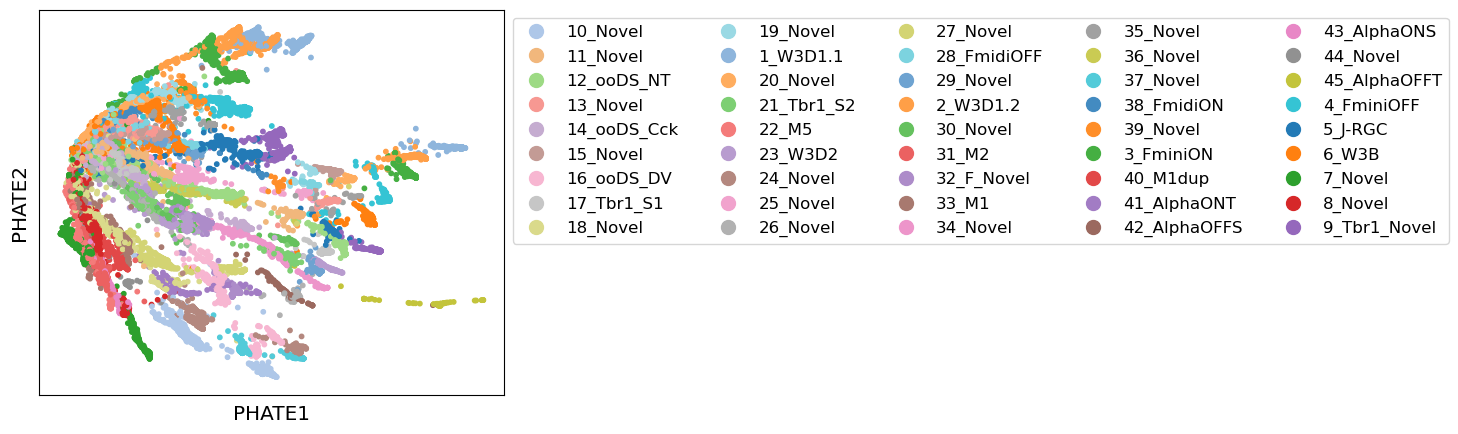

In [16]:
scprep.plot.scatter2d(data_phate, c=mouseRGC_types.new_types,
                      legend_anchor=(1,1), figsize=(6,5), s=10, label_prefix='PHATE', ticks=False)

In [17]:
# beta is the amount of smoothing to do for density estimation
# knn is the number of neighbors used to set the kernel bandwidth
meld_op = meld.MELD(beta=67, knn=7)
sample_densities = meld_op.fit_transform(pca_mouseRGC, sample_labels=mouseRGC_types.new_types)

Building graph on 35699 samples and 90 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 119.85 seconds.
  Calculating affinities...
  Calculated affinities in 3.00 seconds.
Calculated graph and diffusion operator in 123.36 seconds.


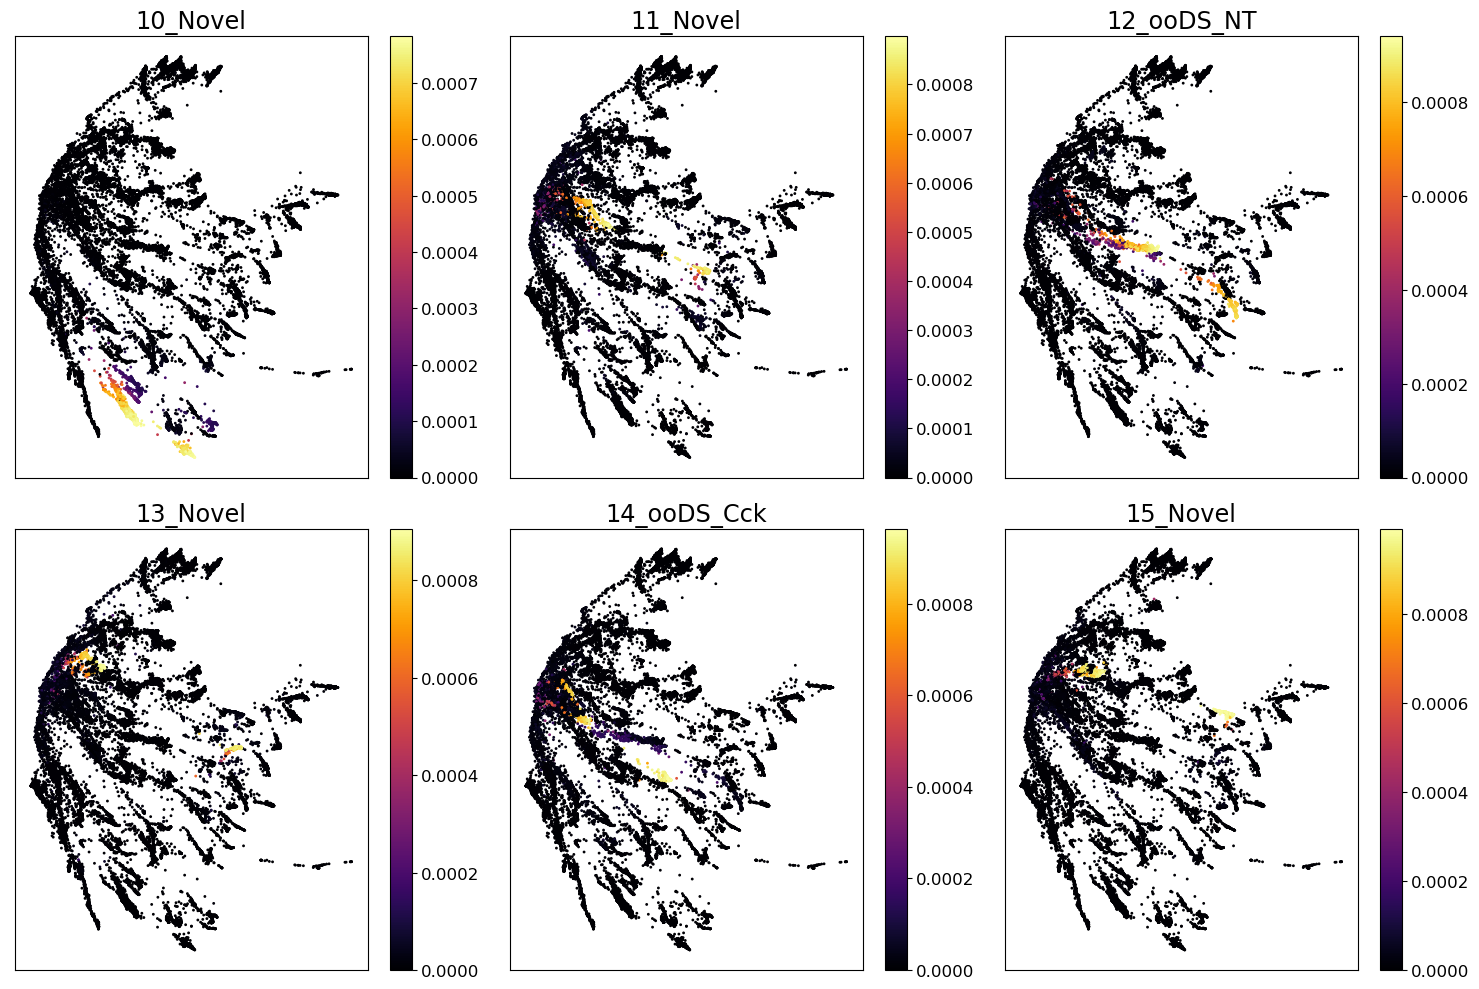

In [18]:
fig, axes = plt.subplots(2,3, figsize=(15,10))

for i, ax in enumerate(axes.flatten()):
    density = sample_densities.iloc[:,i]
    scprep.plot.scatter2d(data_phate, c=density,
                          title=density.name,
                          vmin=0, 
                          ticks=False, ax=ax)
    
fig.tight_layout()

# Read in macaque fovea Rdata

In [189]:
robjects.r['load']("/Users/justinkaufman/Psych_196B_Research/MacaqueRGCObject/RGC_analysis_batchcorr_180629.Rdata")

'foveaRGC'


In [190]:
foveaRGC=robjects.globalenv['foveaRGC']

In [191]:
pca_foveaRGC=foveaRGC.slots['pca.rot']
pca_foveaRGC.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90
M1Fovea1_AAACCTGCAGCTCGCA-1,0.308636,-1.300646,-0.445764,-0.881170,-1.355393,-0.145771,1.609450,0.158350,1.267484,1.904283,...,0.058597,0.258292,-0.511393,0.056427,-0.284813,-1.152702,1.441585,0.269578,0.400271,-1.026125
M1Fovea1_AAACGGGAGCAAATCA-1,-0.726001,-1.181436,-2.299966,-0.893907,-3.497660,0.598706,-8.517934,4.413631,0.369092,0.029077,...,0.507438,1.655370,0.201091,1.661500,-0.066359,1.944669,0.609265,0.116864,-0.686845,1.219012
M1Fovea1_AAACGGGAGGCAGGTT-1,11.038043,1.346830,-5.961965,-2.706764,-0.419104,0.972105,-7.928224,-9.399804,3.676081,3.123801,...,0.480692,-0.226189,-0.467675,0.698312,0.243361,0.469712,0.686296,-0.331429,0.277156,-0.805860
M1Fovea1_AAACGGGAGGCTCATT-1,9.405268,0.927253,-1.343247,0.352856,-1.722554,-0.081043,-0.780999,-0.561064,-0.185240,1.362025,...,0.287506,-0.278059,0.600559,1.534194,0.832075,1.476342,-0.124989,0.028880,-1.864333,0.527062
M1Fovea1_AAAGATGAGGGAACGG-1,4.154747,-0.888533,-1.992973,-0.466301,-0.607817,-0.686002,-1.570389,-0.374177,-1.486711,1.751385,...,-0.895866,-0.077604,1.389174,0.920864,-0.175091,-1.016958,1.181617,0.357578,-1.862464,-0.990632


In [192]:
foveaRGC_types=pd.read_csv("/Users/justinkaufman/Psych_196B_Research/foveaRGC_types.csv") # have to change directory to wherever this file is located on device
foveaRGC_types.rename(columns={"Unnamed: 0": "seq"},inplace=True)
foveaRGC_types

,seq,per_type
0,M1Fovea1_AAACCTGCAGCTCGCA-1,MG_OFF
1,M1Fovea1_AAACGGGAGCAAATCA-1,PG_OFF
2,M1Fovea1_AAACGGGAGGCAGGTT-1,PG_ON
3,M1Fovea1_AAACGGGAGGCTCATT-1,MG_OFF
4,M1Fovea1_AAAGATGAGGGAACGG-1,MG_OFF
...,...,...
30292,M4Fovea3_TTTGCGCAGGCGCTCT-1,MG_ON
30293,M4Fovea3_TTTGCGCGTGACGGTA-1,MG_OFF
30294,M4Fovea3_TTTGGTTTCAACACAC-1,MG_OFF
30295,M4Fovea3_TTTGTCAAGGAGCGTT-1,MG_OFF


In [193]:
fovea_types=[]
for i in foveaRGC_types.seq:
    fovea_types.append(re.search(r"[A-Z][0-9][A-z]+",i).group())

In [194]:
foveaRGC_count=pd.read_csv("/Users/justinkaufman/Psych_196B_Research/foveaRGC_count_data.csv") # have to change directory to wherever this file is located on device

In [195]:
foveaRGC_count.rename(columns={'Unnamed: 0':'gene'}, inplace=True)

In [196]:
foveaRGC_count=foveaRGC_count.loc[foveaRGC_count['gene'].isin(list(orthos['Gene name']))]
foveaRGC_count.reset_index(drop=True, inplace=True)
foveaRGC_count

,gene,M1Fovea1_AAACCTGCAGCTCGCA-1,M1Fovea1_AAACGGGAGCAAATCA-1,M1Fovea1_AAACGGGAGGCAGGTT-1,M1Fovea1_AAACGGGAGGCTCATT-1,M1Fovea1_AAAGATGAGGGAACGG-1,M1Fovea1_AAAGATGTCCAAGTAC-1,M1Fovea1_AAAGCAAAGGTAGCTG-1,M1Fovea1_AAAGCAAAGTATCTCG-1,M1Fovea1_AAAGCAAAGTCGCCGT-1,...,M4Fovea3_TTTATGCCAGGAATGC-1,M4Fovea3_TTTATGCGTCGCTTTC-1,M4Fovea3_TTTATGCGTGGTGTAG-1,M4Fovea3_TTTATGCTCTCAACTT-1,M4Fovea3_TTTCCTCTCAGCCTAA-1,M4Fovea3_TTTGCGCAGGCGCTCT-1,M4Fovea3_TTTGCGCGTGACGGTA-1,M4Fovea3_TTTGGTTTCAACACAC-1,M4Fovea3_TTTGTCAAGGAGCGTT-1,M4Fovea3_TTTGTCATCGTTTAGG-1
0,SH3BP5L,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,1,0
1,TFB2M,1,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,SMYD3,0,1,0,0,0,0,0,0,0,...,0,1,1,1,0,1,1,0,0,1
3,AKT3,3,3,3,2,0,3,0,1,3,...,0,0,0,2,4,0,1,0,4,1
4,CEP170,0,1,0,2,2,4,0,3,2,...,1,1,2,0,1,1,1,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11771,MECP2,1,1,0,0,0,2,1,0,0,...,0,0,0,0,1,2,0,0,1,1
11772,UBL4A,0,1,1,0,2,0,0,0,0,...,0,1,1,2,1,0,1,0,1,0
11773,FAM3A,0,2,0,0,0,3,0,0,0,...,0,0,2,1,0,0,0,1,1,1
11774,GAB3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
def sync_gene_names(df, orthos):
    pd.options.mode.chained_assignment = None 
    count=0
    for i in df.gene:
        try:
            ind=orthos.loc[orthos['Gene name'] == i].index[0]
            df.gene[count]=orthos['Mouse gene name'][ind]
            count+=1
        except:
            count+=1
            continue

In [197]:
sync_gene_names(foveaRGC_count, orthos)

In [198]:
foveaRGC_count

,gene,M1Fovea1_AAACCTGCAGCTCGCA-1,M1Fovea1_AAACGGGAGCAAATCA-1,M1Fovea1_AAACGGGAGGCAGGTT-1,M1Fovea1_AAACGGGAGGCTCATT-1,M1Fovea1_AAAGATGAGGGAACGG-1,M1Fovea1_AAAGATGTCCAAGTAC-1,M1Fovea1_AAAGCAAAGGTAGCTG-1,M1Fovea1_AAAGCAAAGTATCTCG-1,M1Fovea1_AAAGCAAAGTCGCCGT-1,...,M4Fovea3_TTTATGCCAGGAATGC-1,M4Fovea3_TTTATGCGTCGCTTTC-1,M4Fovea3_TTTATGCGTGGTGTAG-1,M4Fovea3_TTTATGCTCTCAACTT-1,M4Fovea3_TTTCCTCTCAGCCTAA-1,M4Fovea3_TTTGCGCAGGCGCTCT-1,M4Fovea3_TTTGCGCGTGACGGTA-1,M4Fovea3_TTTGGTTTCAACACAC-1,M4Fovea3_TTTGTCAAGGAGCGTT-1,M4Fovea3_TTTGTCATCGTTTAGG-1
0,Sh3bp5l,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,1,0
1,Tfb2m,1,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,Smyd3,0,1,0,0,0,0,0,0,0,...,0,1,1,1,0,1,1,0,0,1
3,Akt3,3,3,3,2,0,3,0,1,3,...,0,0,0,2,4,0,1,0,4,1
4,Cep170,0,1,0,2,2,4,0,3,2,...,1,1,2,0,1,1,1,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11771,Mecp2,1,1,0,0,0,2,1,0,0,...,0,0,0,0,1,2,0,0,1,1
11772,Slc10a3,0,1,1,0,2,0,0,0,0,...,0,1,1,2,1,0,1,0,1,0
11773,Fam3a,0,2,0,0,0,3,0,0,0,...,0,0,2,1,0,0,0,1,1,1
11774,Gab3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


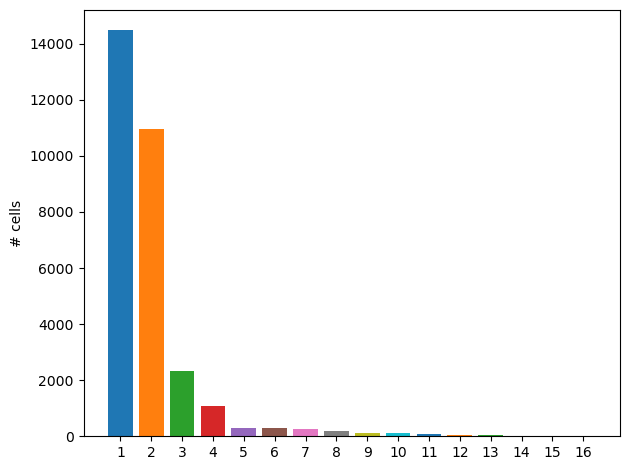

In [199]:
fig, ax = plt.subplots(1)

groups, counts = np.unique(foveaRGC.slots['ident'], return_counts=True)
for i, c in enumerate(counts):
    ax.bar(i, c)
    
ax.set_xticks(np.arange(i+1))
ax.set_xticklabels(groups)
ax.set_ylabel('# cells')

fig.tight_layout()

In [200]:
phate_op = phate.PHATE(n_jobs=-1)
data_phate = phate_op.fit_transform(pca_foveaRGC)

Calculating PHATE...
  Running PHATE on 30297 observations and 90 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 35.00 seconds.
    Calculating affinities...
    Calculated affinities in 6.08 seconds.
  Calculated graph and diffusion operator in 41.13 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 4.40 seconds.
    Calculating KMeans...
    Calculated KMeans in 11.58 seconds.
  Calculated landmark operator in 16.78 seconds.
  Calculating optimal t...
    Automatically selected t = 33
  Calculated optimal t in 8.57 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.77 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.98 seconds.
Calculated PHATE in 70.25 seconds.


### Phate map by fovea types

/opt/miniconda3/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

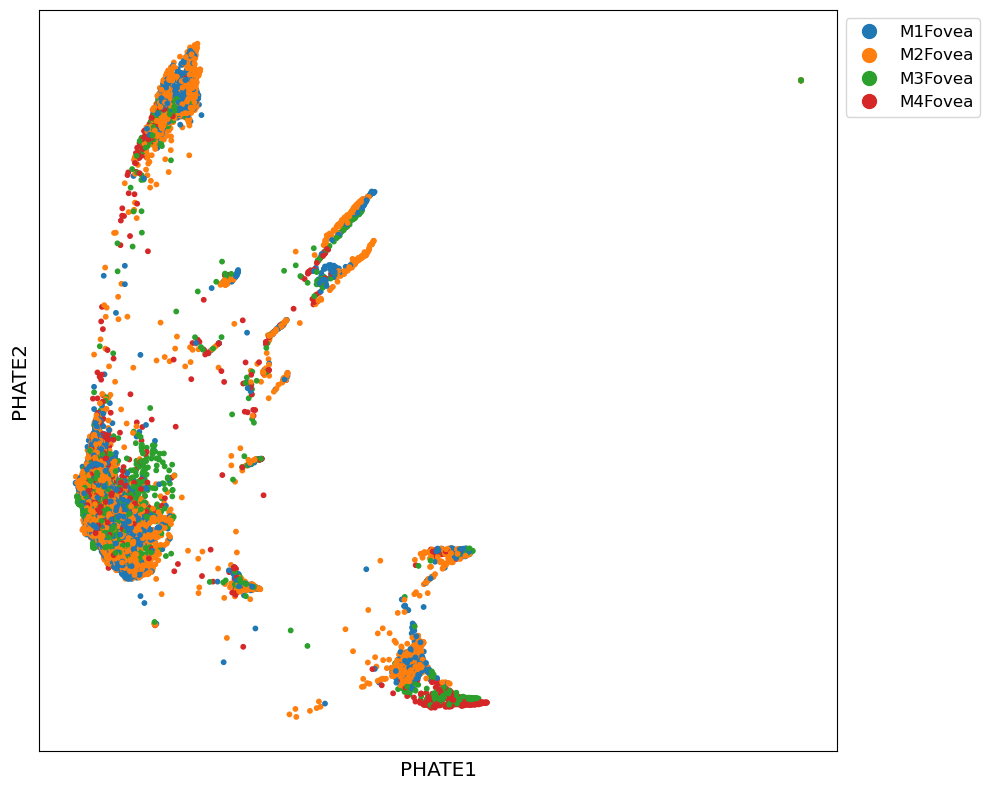

In [201]:
scprep.plot.scatter2d(data_phate, c=pd.DataFrame(fovea_types),
                      legend_anchor=(1,1), figsize=(10,8), s=10, label_prefix='PHATE', ticks=False)

### Phate plot by ident label

/opt/miniconda3/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

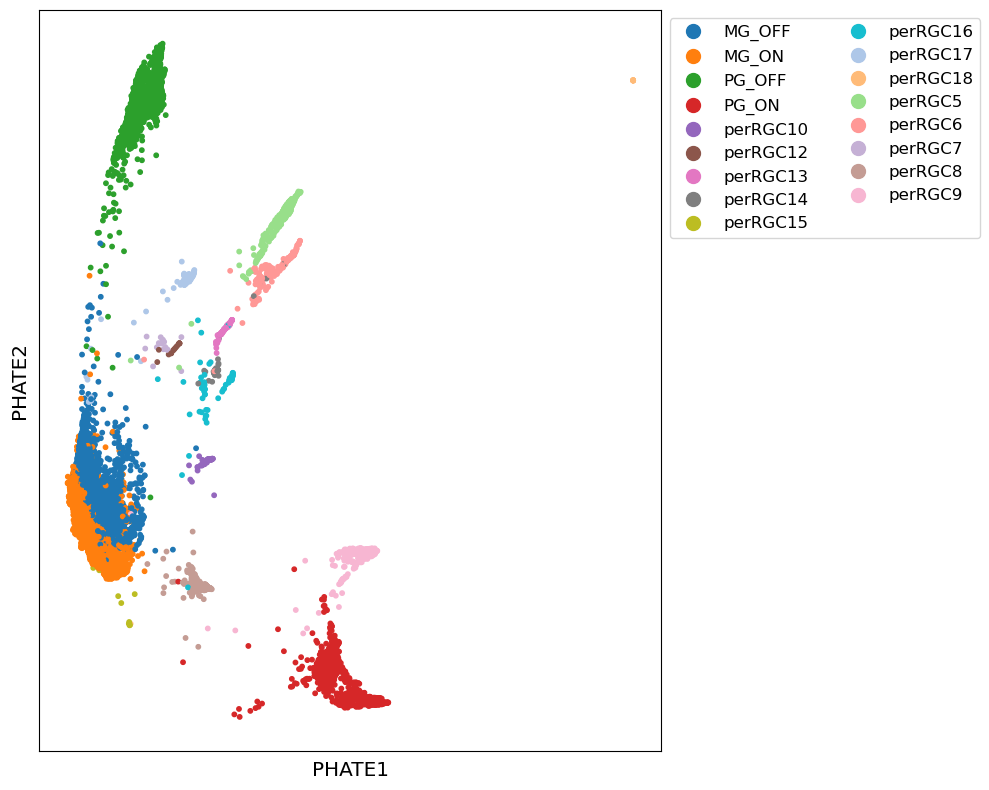

In [202]:
scprep.plot.scatter2d(data_phate, c=foveaRGC_types.per_type,
                      legend_anchor=(1,1), figsize=(10,8), s=10, label_prefix='PHATE', ticks=False)

# Read in macaque peripheral Rdata

In [19]:
robjects.r['load']("/Users/justinkaufman/Psych_196B_Research/MacaqueRGCObject/RGC_analysis_periphery_180629.Rdata")

'perRGC'


In [20]:
perRGC=robjects.globalenv['perRGC']

In [21]:
pca_perRGC=perRGC.slots['pca.rot']
pca_perRGC.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90
M1PerCD90S1_AAACCTGTCTCTGCTG-1,5.006076,-4.747816,0.460214,-1.190186,-0.740854,0.543048,-0.014019,-0.085227,-0.307906,0.591207,...,-0.750463,-0.097573,0.837528,2.101504,-1.453087,-1.557716,-0.515973,0.408030,-0.935876,-0.440098
M1PerCD90S1_AAACGGGAGTGATCGG-1,-2.250446,-1.209849,0.002132,0.702885,-0.938112,-1.023753,-0.615205,0.184911,0.012429,1.192812,...,0.071453,-0.547315,1.453057,1.435691,-0.314433,-0.364913,-0.375654,-0.274106,0.100351,-1.883931
M1PerCD90S1_AAACGGGCAATAGCGG-1,1.576478,10.485785,-10.318696,-2.853375,9.544408,-2.596284,5.397108,2.074000,2.790835,5.387470,...,-3.259582,1.350168,0.875363,2.527203,2.217478,2.809263,0.670326,-0.826871,0.573374,-0.633461
M1PerCD90S1_AAACGGGCACGAGAGT-1,5.740340,-1.837878,-1.135696,-0.814176,3.049728,-0.759117,1.332249,-0.460859,0.615729,-1.125935,...,0.038149,-0.918872,-0.517958,0.783845,-0.775768,0.271670,0.792284,-0.201425,0.327753,0.507601
M1PerCD90S1_AAAGATGCACTGCCAG-1,5.329309,-4.141321,-3.953011,-5.559592,0.467053,6.118447,1.187642,-2.051990,2.872528,-3.230730,...,-1.009465,0.949142,0.001750,-0.418092,-0.054548,0.087895,0.624669,0.067952,1.502239,1.612731


In [22]:
perRGC_types=pd.read_csv("/Users/justinkaufman/Psych_196B_Research/perRGC_types.csv") # have to change directory to wherever this file is located on device
perRGC_types.rename(columns={"Unnamed: 0": "seq"},inplace=True)
perRGC_types

,seq,type
0,M1PerCD90S1_AAACCTGTCTCTGCTG-1,MG_OFF
1,M1PerCD90S1_AAACGGGAGTGATCGG-1,MG_OFF
2,M1PerCD90S1_AAACGGGCAATAGCGG-1,perRGC8
3,M1PerCD90S1_AAACGGGCACGAGAGT-1,MG_ON
4,M1PerCD90S1_AAAGATGCACTGCCAG-1,MG_ON
...,...,...
11718,M4PerCD73S2_TTCCCAGCAGTAACGG-1,perRGC10
11719,M4PerCD73S2_TTCTACAGTTCCACGG-1,perRGC16
11720,M4PerCD73S2_TTCTCCTGTAAGGATT-1,MG_OFF
11721,M4PerCD73S2_TTGAACGCACTGTGTA-1,MG_ON


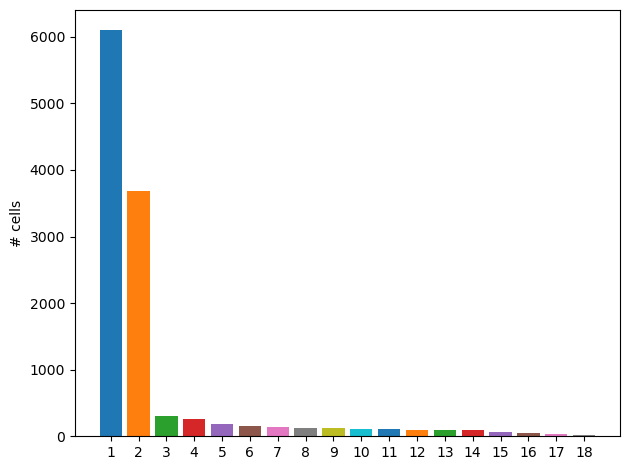

In [23]:
fig, ax = plt.subplots(1)

groups, counts = np.unique(perRGC.slots['ident'], return_counts=True)
for i, c in enumerate(counts):
    ax.bar(i, c)
    
ax.set_xticks(np.arange(i+1))
ax.set_xticklabels(groups)
ax.set_ylabel('# cells')

fig.tight_layout()

In [24]:
phate_op = phate.PHATE(n_jobs=-1)
data_phate = phate_op.fit_transform(pca_perRGC)

Calculating PHATE...
  Running PHATE on 11723 observations and 90 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 6.75 seconds.
    Calculating affinities...
    Calculated affinities in 1.03 seconds.
  Calculated graph and diffusion operator in 7.79 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.10 seconds.
    Calculating KMeans...
    Calculated KMeans in 7.50 seconds.
  Calculated landmark operator in 9.07 seconds.
  Calculating optimal t...
    Automatically selected t = 32
  Calculated optimal t in 6.78 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.68 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.51 seconds.
Calculated PHATE in 26.85 seconds.


### Phate plot by ident label

/opt/miniconda3/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

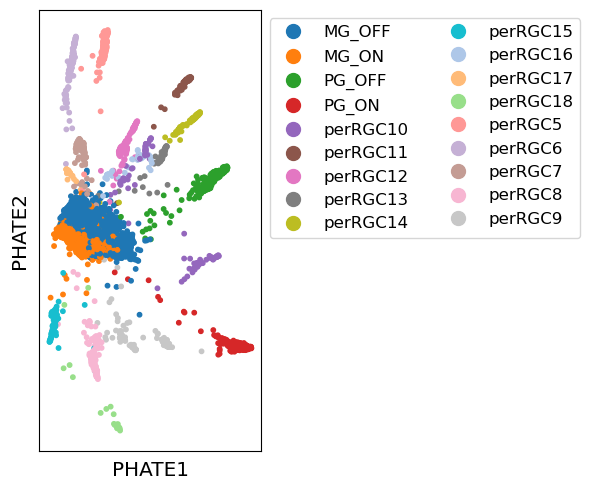

In [25]:
scprep.plot.scatter2d(data_phate, c=perRGC_types.type,
                      legend_anchor=(1,1), figsize=(6,5), s=10, label_prefix='PHATE', ticks=False)

In [26]:
# beta is the amount of smoothing to do for density estimation
# knn is the number of neighbors used to set the kernel bandwidth
meld_op = meld.MELD(beta=67, knn=7)
sample_densities = meld_op.fit_transform(pca_perRGC, sample_labels=perRGC_types.type)

Building graph on 11723 samples and 90 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 8.95 seconds.
  Calculating affinities...
  Calculated affinities in 1.46 seconds.
Calculated graph and diffusion operator in 10.59 seconds.


### Sample densities on phate plot

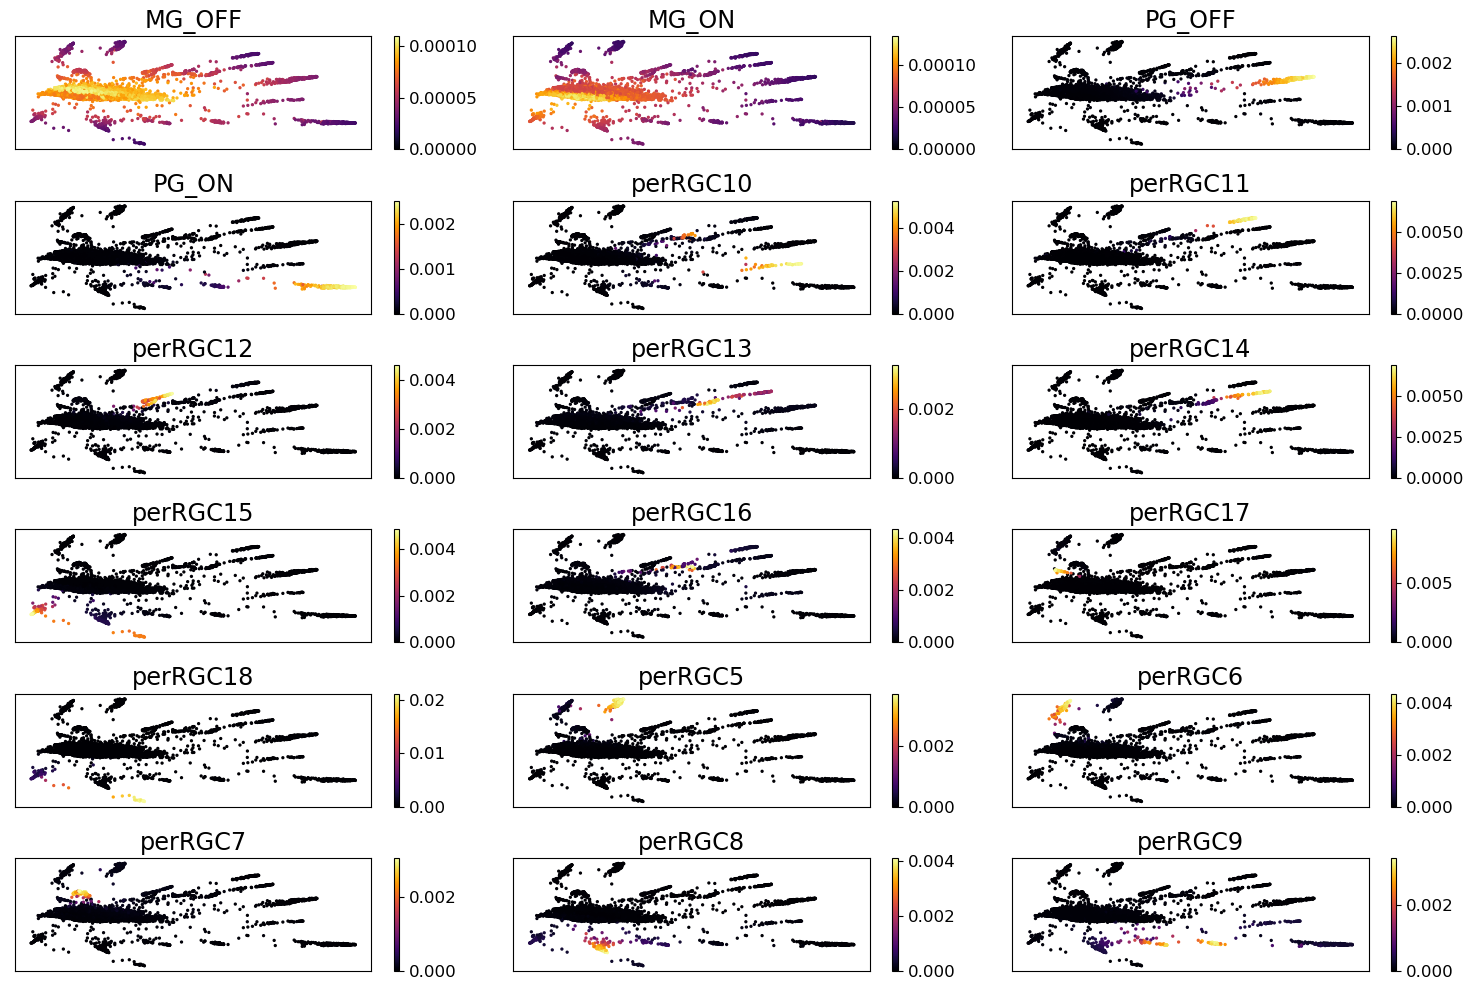

In [28]:
fig, axes = plt.subplots(6,3, figsize=(15,10))

for i, ax in enumerate(axes.flatten()):
    density = sample_densities.iloc[:,i]
    scprep.plot.scatter2d(data_phate, c=density,
                          title=density.name,
                          vmin=0, 
                          ticks=False, ax=ax)
    
fig.tight_layout()

In [52]:
# next is relative likelihood in each condition

In [272]:
perRGC_count=pd.read_csv("/Users/justinkaufman/Psych_196B_Research/perRGC_count_data.csv") # have to change directory to wherever this file is located on device
perRGC_count.rename(columns={'Unnamed: 0':'gene'}, inplace=True)
perRGC_count=perRGC_count.loc[perRGC_count['gene'].isin(list(orthos['Gene name']))]
perRGC_count.reset_index(drop=True, inplace=True)
perRGC_count

,gene,M1PerCD90S1_AAACCTGTCTCTGCTG-1,M1PerCD90S1_AAACGGGAGTGATCGG-1,M1PerCD90S1_AAACGGGCAATAGCGG-1,M1PerCD90S1_AAACGGGCACGAGAGT-1,M1PerCD90S1_AAAGATGCACTGCCAG-1,M1PerCD90S1_AAAGATGCATGTAGTC-1,M1PerCD90S1_AAAGATGTCAGCTCTC-1,M1PerCD90S1_AAAGCAAAGCGCCTTG-1,M1PerCD90S1_AAAGCAAGTTAAGTAG-1,...,M4PerCD73S2_TGGTTAGTCACCCTCA-1,M4PerCD73S2_TGTCCCATCGTCCGTT-1,M4PerCD73S2_TTAACTCTCGCGTTTC-1,M4PerCD73S2_TTAGGCACAGCTCCGA-1,M4PerCD73S2_TTAGTTCAGCTGCAAG-1,M4PerCD73S2_TTCCCAGCAGTAACGG-1,M4PerCD73S2_TTCTACAGTTCCACGG-1,M4PerCD73S2_TTCTCCTGTAAGGATT-1,M4PerCD73S2_TTGAACGCACTGTGTA-1,M4PerCD73S2_TTGGCAAAGGGAGTAA-1
0,SH3BP5L,0,0,0,0,0,0,0,1,0,...,2,0,0,1,0,0,1,0,0,0
1,TFB2M,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,SMYD3,0,0,0,0,0,0,2,0,2,...,0,1,0,1,0,1,0,0,0,0
3,AKT3,4,4,2,2,3,1,1,0,0,...,1,1,2,1,2,1,1,1,4,0
4,CEP170,1,2,4,1,4,3,0,2,1,...,2,1,4,1,2,2,8,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11771,MECP2,1,1,1,0,1,1,0,0,0,...,0,0,2,0,0,0,4,1,0,0
11772,UBL4A,0,0,1,0,0,1,1,2,0,...,0,1,0,1,1,2,8,0,3,0
11773,FAM3A,1,1,0,1,0,0,0,0,0,...,1,0,1,0,1,1,1,0,1,0
11774,GAB3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
sync_gene_names(perRGC_count, orthos)

In [113]:
perRGC_count

,gene,M1PerCD90S1_AAACCTGTCTCTGCTG-1,M1PerCD90S1_AAACGGGAGTGATCGG-1,M1PerCD90S1_AAACGGGCAATAGCGG-1,M1PerCD90S1_AAACGGGCACGAGAGT-1,M1PerCD90S1_AAAGATGCACTGCCAG-1,M1PerCD90S1_AAAGATGCATGTAGTC-1,M1PerCD90S1_AAAGATGTCAGCTCTC-1,M1PerCD90S1_AAAGCAAAGCGCCTTG-1,M1PerCD90S1_AAAGCAAGTTAAGTAG-1,...,M4PerCD73S2_TGGTTAGTCACCCTCA-1,M4PerCD73S2_TGTCCCATCGTCCGTT-1,M4PerCD73S2_TTAACTCTCGCGTTTC-1,M4PerCD73S2_TTAGGCACAGCTCCGA-1,M4PerCD73S2_TTAGTTCAGCTGCAAG-1,M4PerCD73S2_TTCCCAGCAGTAACGG-1,M4PerCD73S2_TTCTACAGTTCCACGG-1,M4PerCD73S2_TTCTCCTGTAAGGATT-1,M4PerCD73S2_TTGAACGCACTGTGTA-1,M4PerCD73S2_TTGGCAAAGGGAGTAA-1
0,Sh3bp5l,0,0,0,0,0,0,0,1,0,...,2,0,0,1,0,0,1,0,0,0
1,Tfb2m,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Smyd3,0,0,0,0,0,0,2,0,2,...,0,1,0,1,0,1,0,0,0,0
3,Akt3,4,4,2,2,3,1,1,0,0,...,1,1,2,1,2,1,1,1,4,0
4,Cep170,1,2,4,1,4,3,0,2,1,...,2,1,4,1,2,2,8,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11771,Mecp2,1,1,1,0,1,1,0,0,0,...,0,0,2,0,0,0,4,1,0,0
11772,Slc10a3,0,0,1,0,0,1,1,2,0,...,0,1,0,1,1,2,8,0,3,0
11773,Fam3a,1,1,0,1,0,0,0,0,0,...,1,0,1,0,1,1,1,0,1,0
11774,Gab3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
def sync_gene_names(df, orthos):
    pd.options.mode.chained_assignment = None 
    count=0
    for i in df.gene:
        try:
            ind=orthos.loc[orthos['Gene name'] == i].index[0]
            df.gene[count]=orthos['Mouse gene name'][ind]
            count+=1
        except:
            count+=1
            continue

# Merge the per and mouse datasets

In [114]:
# merged_macaque_count=pd.merge(foveaRGC_count, perRGC_count, how="outer", on=["gene"])

In [115]:
merged_count=pd.merge(mouseRGC_count, perRGC_count, how="outer", on=["gene"])
merged_count.fillna(0,inplace=True)
merged_count

,gene,aRGC1_AAACCTGAGAATCTCC-1,aRGC1_AAACCTGAGCGACGTA-1,aRGC1_AAACCTGGTAAATGAC-1,aRGC1_AAACCTGTCAAGGCTT-1,aRGC1_AAACGGGAGCAGCGTA-1,aRGC1_AAACGGGCAATCTACG-1,aRGC1_AAACGGGCACCACCAG-1,aRGC1_AAACGGGCAGCGTTCG-1,aRGC1_AAACGGGCAGGTTTCA-1,...,M4PerCD73S2_TGGTTAGTCACCCTCA-1,M4PerCD73S2_TGTCCCATCGTCCGTT-1,M4PerCD73S2_TTAACTCTCGCGTTTC-1,M4PerCD73S2_TTAGGCACAGCTCCGA-1,M4PerCD73S2_TTAGTTCAGCTGCAAG-1,M4PerCD73S2_TTCCCAGCAGTAACGG-1,M4PerCD73S2_TTCTACAGTTCCACGG-1,M4PerCD73S2_TTCTCCTGTAAGGATT-1,M4PerCD73S2_TTGAACGCACTGTGTA-1,M4PerCD73S2_TTGGCAAAGGGAGTAA-1
0,Sox17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Mrpl15,0.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,0.0,...,0.0,1.0,2.0,0.0,1.0,2.0,1.0,1.0,3.0,2.0
2,Lypla1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,...,0.0,1.0,3.0,2.0,1.0,1.0,1.0,0.0,1.0,2.0
3,Tcea1,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,3.0,4.0,4.0,1.0,0.0,0.0
4,Rgs20,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13116,Mrln,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13117,Frat1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
13118,Slf2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13119,Itprip,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
merged_count_test=merged_count.set_index('gene')
merged_count_test=merged_count_test.T
merged_count_test

gene,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Oprk1,Npbwr1,Rb1cc1,St18,...,Fam91a1,Tmem249,Vps28,C030006K11Rik,Frmpd2,Mrln,Frat1,Slf2,Itprip,Ints6l
aRGC1_AAACCTGAGAATCTCC-1,0.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aRGC1_AAACCTGAGCGACGTA-1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aRGC1_AAACCTGGTAAATGAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aRGC1_AAACCTGTCAAGGCTT-1,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aRGC1_AAACGGGAGCAGCGTA-1,0.0,2.0,1.0,1.0,1.0,3.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M4PerCD73S2_TTCCCAGCAGTAACGG-1,0.0,2.0,1.0,4.0,0.0,2.0,0.0,0.0,4.0,0.0,...,0.0,0.0,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
M4PerCD73S2_TTCTACAGTTCCACGG-1,0.0,1.0,1.0,4.0,1.0,3.0,0.0,0.0,3.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M4PerCD73S2_TTCTCCTGTAAGGATT-1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M4PerCD73S2_TTGAACGCACTGTGTA-1,0.0,3.0,1.0,0.0,0.0,5.0,0.0,0.0,2.0,0.0,...,1.0,0.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [117]:
merged_count_norm = StandardScaler().fit_transform(merged_count_test)

In [118]:
pca = PCA(n_components=90)
principalComponents = pca.fit_transform(merged_count_norm)

In [119]:
principalDf = pd.DataFrame(principalComponents)

In [120]:
principalDf

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,8.269860,-8.911668,12.020370,13.763994,-0.845186,8.450451,10.185088,-9.119981,8.674211,5.721089,...,-0.106196,-1.337784,-0.356282,-0.863413,-1.615136,-0.351208,0.934738,-0.184728,-0.148617,-0.117921
1,-25.187963,-9.359296,10.868584,6.068020,2.410562,11.804068,8.112035,-1.381259,2.587684,2.459499,...,0.876263,-0.900019,-0.689122,0.580133,-0.203632,-0.203965,-0.023084,1.016533,-1.884851,-0.576653
2,-24.974199,-10.798178,6.818108,6.281821,2.209406,7.929352,9.310149,-1.950584,0.759423,2.286807,...,0.175178,0.464972,-1.819219,-0.474072,2.579829,-1.507524,-0.055219,0.763857,-3.279296,0.256273
3,33.206116,-1.826560,31.959834,7.105253,11.112575,-1.910577,6.462248,-0.343577,3.668173,-2.273592,...,-2.638350,-1.005760,1.376947,-0.170246,-1.343470,-1.046746,1.725229,-1.616252,-3.214293,-2.664247
4,59.124355,-8.478407,-0.471730,20.602058,-13.472478,-9.041482,12.136214,-5.274290,-6.794235,1.735828,...,-0.261169,-0.222146,-1.822277,-0.225295,1.905716,1.303179,0.713664,-2.655762,-0.088070,-0.018362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47417,16.143711,57.852707,-12.969851,20.313373,11.629791,9.874421,-11.070912,2.885717,5.854490,0.866500,...,-1.587674,-1.843431,-2.959950,3.098749,-0.846959,-8.768508,-0.618203,-6.636385,-2.978628,-0.755932
47418,36.930827,81.265985,-20.852709,29.464094,11.009226,21.635168,-27.648938,5.517190,-0.324070,3.521058,...,1.772046,3.796219,-6.413149,-4.083032,-1.037719,2.807186,6.076995,-8.627210,10.044910,0.243729
47419,-25.734484,22.180737,2.868608,-3.097334,0.651264,2.075846,-1.262073,-4.990648,-1.313090,1.250429,...,1.241632,-2.058609,0.917225,-0.709747,0.990423,0.423998,0.840139,-1.821768,1.721171,-2.253623
47420,4.957025,60.149345,10.818581,-11.467043,-5.778018,-1.525475,3.325716,-5.167326,0.013887,7.999363,...,-0.134209,-2.766382,0.296764,0.046097,5.016755,-1.342731,-3.769649,2.549960,-5.494500,1.827214


In [207]:
phate_op = phate.PHATE(n_jobs=-1)
data_phate = phate_op.fit_transform(principalDf)

Calculating PHATE...
  Running PHATE on 47422 observations and 90 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 56.49 seconds.
    Calculating affinities...
    Calculated affinities in 0.52 seconds.
  Calculated graph and diffusion operator in 57.05 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 4.25 seconds.
    Calculating KMeans...
    Calculated KMeans in 13.66 seconds.
  Calculated landmark operator in 19.07 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 11.35 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.88 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.07 seconds.
Calculated PHATE in 91.46 seconds.


In [122]:
ident=[]
for i in merged_count_test.index:
    try:
        ind=mouseRGC_types.loc[mouseRGC_types['seq'] == i].index[0]
        ident.append(mouseRGC_types.new_types[ind])
    except:
#         try:
#             ind=foveaRGC_types.loc[foveaRGC_types['seq'] == i].index[0]
#             ident.append(foveaRGC_types.per_type[ind])
#         except:
        try:
            ind=perRGC_types.loc[perRGC_types['seq'] == i].index[0]
            ident.append(perRGC_types.type[ind])
        except:
            continue

In [123]:
sample=[]
for i in merged_count_test.index:
    try:
        samp=mouseRGC_types.loc[mouseRGC_types['seq'] == i].index[0]
        sample.append('mouse')
    except:
#         try:
#             samp=foveaRGC_types.loc[foveaRGC_types['seq'] == i].index[0]
#             sample.append('fovea')
#         except:
        try:
            samp=perRGC_types.loc[perRGC_types['seq'] == i].index[0]
            sample.append('peripheral')
        except:
            continue

### Coloring Phate Plot by Sample Labels

/opt/miniconda3/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

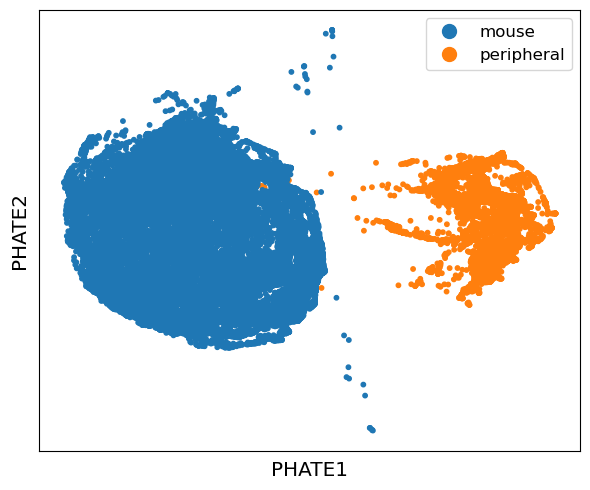

In [124]:
scprep.plot.scatter2d(data_phate, c= sample,
                      legend_anchor=(1,1), figsize=(6,5), s=10, label_prefix='PHATE', ticks=False)

### Coloring Phate Plot By Ident Labels

/opt/miniconda3/lib/python3.9/site-packages/scprep/plot/utils.py:99: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.

/opt/miniconda3/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

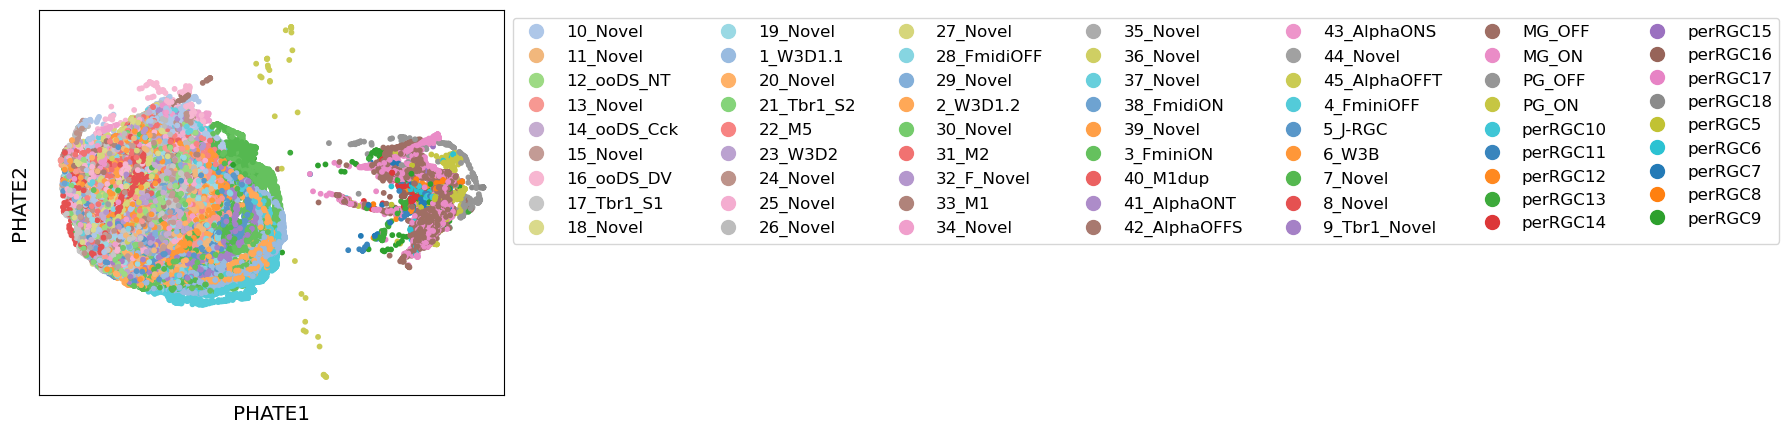

In [125]:
scprep.plot.scatter2d(data_phate, c= ident,
                      legend_anchor=(1,1), figsize=(6,5), s=10, label_prefix='PHATE', ticks=False)

In [203]:
# beta is the amount of smoothing to do for density estimation
# knn is the number of neighbors used to set the kernel bandwidth
meld_op = meld.MELD(beta=67, knn=10)
sample_densities = meld_op.fit_transform(principalDf, sample_labels=pd.DataFrame(ident))

Building graph on 47422 samples and 90 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 185.01 seconds.
  Calculating affinities...
  Calculated affinities in 0.82 seconds.
Calculated graph and diffusion operator in 186.95 seconds.


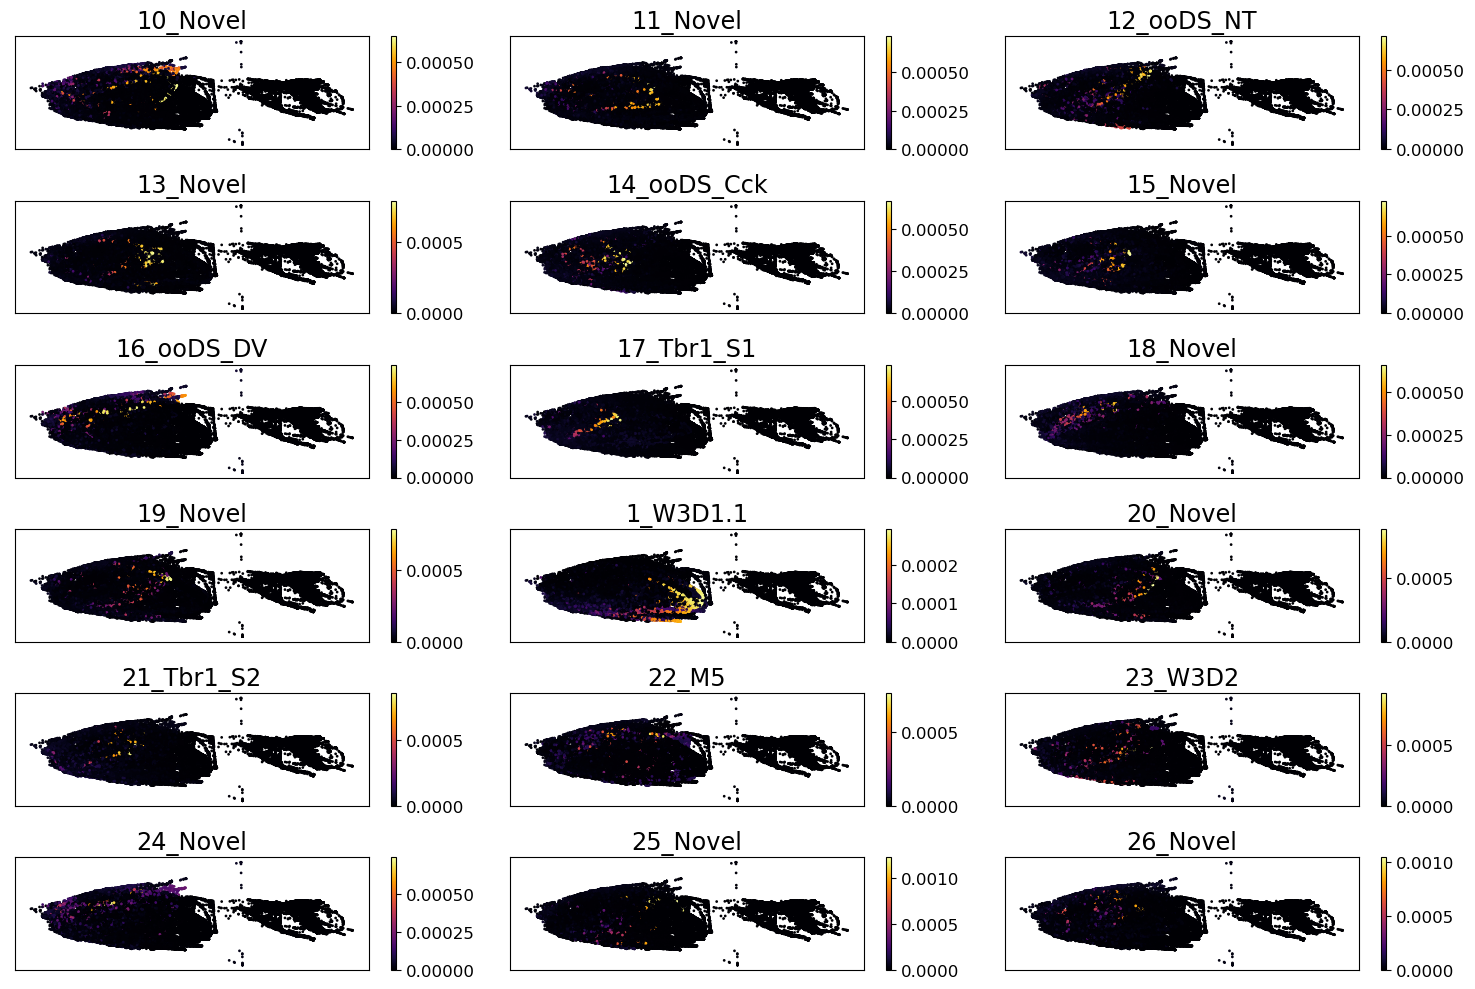

In [208]:
fig, axes = plt.subplots(6,3, figsize=(15,10))

for i, ax in enumerate(axes.flatten()):
    density = sample_densities.iloc[:,i]
    scprep.plot.scatter2d(data_phate, c=density,
                          title=density.name,
                          vmin=0, 
                          ticks=False, ax=ax)
    
fig.tight_layout()

In [209]:
# beta is the amount of smoothing to do for density estimation
# knn is the number of neighbors used to set the kernel bandwidth
meld_op = meld.MELD(beta=67, knn=10)
sample_densities = meld_op.fit_transform(principalDf, sample_labels=pd.DataFrame(sample))

Building graph on 47422 samples and 90 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 198.27 seconds.
  Calculating affinities...
  Calculated affinities in 0.79 seconds.
Calculated graph and diffusion operator in 199.99 seconds.


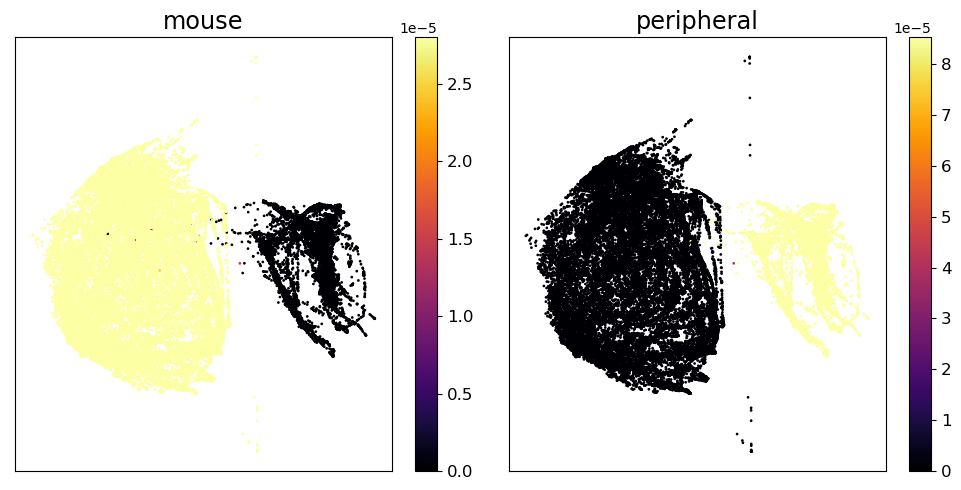

In [213]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

for i, ax in enumerate(axes.flatten()):
    density = sample_densities.iloc[:,i]
    scprep.plot.scatter2d(data_phate, c=density,
                          title=density.name,
                          vmin=0, 
                          ticks=False, ax=ax)
    
fig.tight_layout()

# SAM

In [40]:
import sys

In [43]:
from samalg.gui import SAMGUI
from samap.mapping import SAMAP
from samalg import SAM
from samap.analysis import (get_mapping_scores, GenePairFinder, transfer_annotations,
                            sankey_plot, chord_plot, CellTypeTriangles, 
                            ParalogSubstitutions, FunctionalEnrichment,
                            convert_eggnog_to_homologs, GeneTriangles)

In [41]:
!{sys.executable} -m pip install sam-algorithm

In [157]:
per_count.to_csv('per_count.csv')
mouse_count.to_csv('mouse_count.csv')

In [163]:
sammer=SAM()
sammer.load_data('per_count.csv')

/opt/miniconda3/lib/python3.9/site-packages/samalg/__init__.py:423: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.



In [170]:
sammer2=SAM()
sammer2.load_data('mouse_count.csv')

/opt/miniconda3/lib/python3.9/site-packages/samalg/__init__.py:423: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.



/opt/miniconda3/lib/python3.9/site-packages/samalg/__init__.py:87: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.



RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.7714219681273372
Iteration: 2, Convergence: 0.016404989304483728
Computing the UMAP embedding...
Elapsed time: 101.63774704933167 seconds


<AxesSubplot:>

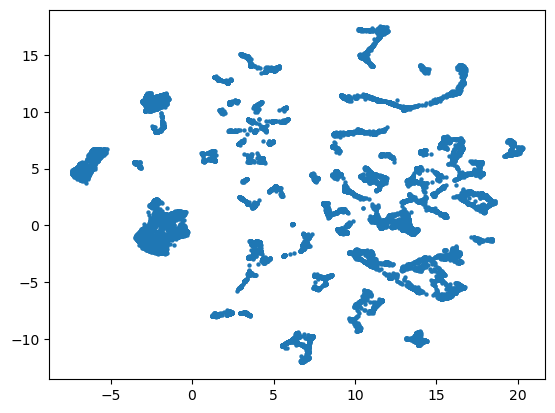

In [126]:
sam=SAM(counts=merged_count_test)
sam.preprocess_data() # log transforms and filters the data
sam.run() #run with default parameters
sam.scatter()

In [218]:
sam_gui3 = SAMGUI(sam)
sam_gui3.SamPlot

    'data': [{'hoverinfo': 'text',
              'marker': {'size'…

In [214]:
sam_gui = SAMGUI(sam1)
sam_gui.SamPlot

    'data': [{'hoverinfo': 'text',
              'marker': {'size'…

KeyError: 'X_knn_avg'

In [216]:
sam_gui2 = SAMGUI(sam2)
sam_gui2.SamPlot

    'data': [{'hoverinfo': 'text',
              'marker': {'size'…

In [140]:
mouse_count=mouseRGC_count.set_index('gene')
mouse_count=mouse_count.T
mouse_count=mouse_count.astype('float32')

In [138]:
per_count=perRGC_count.set_index('gene')
per_count=per_count.T
per_count=per_count.astype('float32')

/opt/miniconda3/lib/python3.9/site-packages/samalg/__init__.py:225: RuntimeWarning:

divide by zero encountered in true_divide



RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.5498234921433457
Iteration: 2, Convergence: 0.025904053294469546
Iteration: 3, Convergence: 0.03588676048261214
Iteration: 4, Convergence: 0.0331485177258224
Iteration: 5, Convergence: 0.01375531886170817
Iteration: 6, Convergence: 0.013516886488406278
Iteration: 7, Convergence: 0.013959710531755381
Iteration: 8, Convergence: 0.011958039133357894
Iteration: 9, Convergence: 0.019541818507408815
Computing the UMAP embedding...
Elapsed time: 115.10777401924133 seconds


<AxesSubplot:>

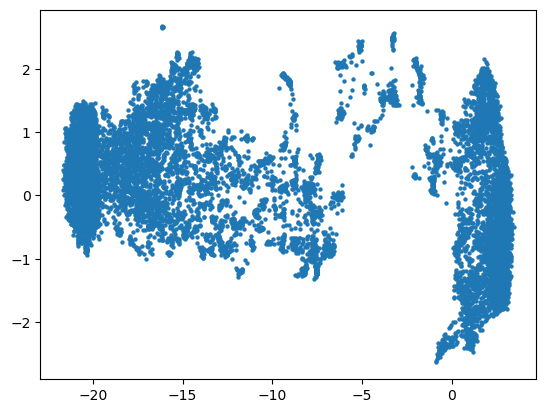

In [171]:
sammer.preprocess_data() # log transforms and filters the data
sammer.run() #run with default parameters
sammer.scatter()

/opt/miniconda3/lib/python3.9/site-packages/samalg/__init__.py:225: RuntimeWarning:

divide by zero encountered in true_divide



RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.5027153787752673
Iteration: 2, Convergence: 0.057004214449419416
Iteration: 3, Convergence: 0.03826939791172607
Iteration: 4, Convergence: 0.03871864453431203
Iteration: 5, Convergence: 0.013041294049502822
Iteration: 6, Convergence: 0.037828840059465976
Iteration: 7, Convergence: 0.03678382272118446
Iteration: 8, Convergence: 0.013626897390523406
Iteration: 9, Convergence: 0.014016779135801703
Computing the UMAP embedding...
Elapsed time: 138.46327590942383 seconds


<AxesSubplot:>

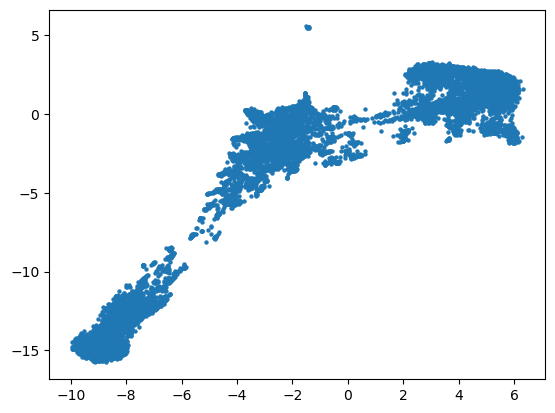

In [174]:
sammer2.preprocess_data() # log transforms and filters the data
sammer2.run() #run with default parameters
sammer2.scatter()

In [141]:
sam1=SAM(counts=mouse_count)
sam2=SAM(counts=per_count)

RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.7528591707319291
Iteration: 2, Convergence: 0.02704780009080551
Computing the UMAP embedding...
Elapsed time: 75.94578266143799 seconds


<AxesSubplot:>

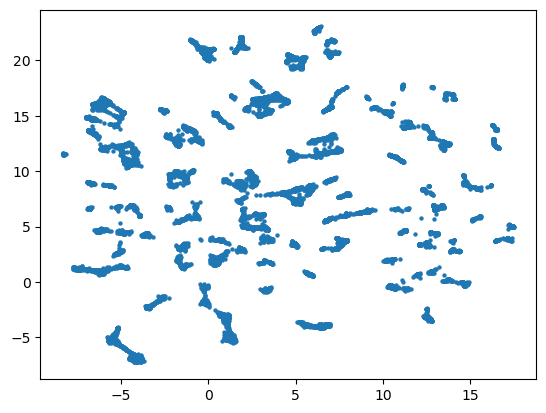

In [148]:
sam1.preprocess_data() # log transforms and filters the data
sam1.run() #run with default parameters
sam1.scatter()

RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.6691916876984149
Iteration: 2, Convergence: 0.03378882455436957
Computing the UMAP embedding...
Elapsed time: 25.857795000076294 seconds


<AxesSubplot:>

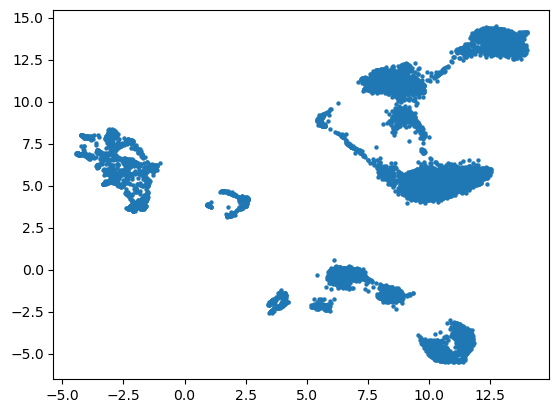

In [147]:
sam2.preprocess_data() # log transforms and filters the data
sam2.run() #run with default parameters
sam2.scatter()

In [185]:
sam1.adata.obs

,leiden_clusters
aRGC1_AAACCTGAGAATCTCC-1,48
aRGC1_AAACCTGAGCGACGTA-1,98
aRGC1_AAACCTGGTAAATGAC-1,98
aRGC1_AAACCTGTCAAGGCTT-1,43
aRGC1_AAACGGGAGCAGCGTA-1,75
...,...
aRGC10_TTTGTCAAGGAACTGC-1,68
aRGC10_TTTGTCAAGTAGGTGC-1,68
aRGC10_TTTGTCACATGTAAGA-1,69
aRGC10_TTTGTCAGTCTAGGTT-1,17


# SAMap

In [186]:
sams = {'mouse':sam1,'mac':sam2}

In [187]:
sm = SAMAP(sams, f_maps = '/maps/')

FileExistsError: BLAST mapping tables with the input IDs (leiden_clusters and mac) not found in the specified path.

In [188]:
per_count

gene,Sh3bp5l,Tfb2m,Smyd3,Akt3,Cep170,Pld5,Opn3,Fh1,Rgs7,Grem2,...,Arhgap4,Naa10,Renbp,Hcfc1,Irak1,Mecp2,Slc10a3,Fam3a,Gab3,Mpp1
M1PerCD90S1_AAACCTGTCTCTGCTG-1,0.0,1.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
M1PerCD90S1_AAACGGGAGTGATCGG-1,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
M1PerCD90S1_AAACGGGCAATAGCGG-1,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0,...,0.0,3.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0
M1PerCD90S1_AAACGGGCACGAGAGT-1,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
M1PerCD90S1_AAAGATGCACTGCCAG-1,0.0,0.0,0.0,3.0,4.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M4PerCD73S2_TTCCCAGCAGTAACGG-1,0.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0,5.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,3.0
M4PerCD73S2_TTCTACAGTTCCACGG-1,1.0,0.0,0.0,1.0,8.0,0.0,1.0,0.0,1.0,0.0,...,0.0,2.0,0.0,1.0,0.0,4.0,8.0,1.0,0.0,0.0
M4PerCD73S2_TTCTCCTGTAAGGATT-1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
M4PerCD73S2_TTGAACGCACTGTGTA-1,0.0,0.0,0.0,4.0,3.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,2.0


# Liger 

In [307]:
import pyliger
import scanpy as sc

In [306]:
mouseRGC_count_temp=mouseRGC_count.copy()
mouseRGC_count_temp.set_index('gene', inplace=True)
mouseRGC_count_temp.index.name = None

perRGC_count_temp=perRGC_count.copy()
perRGC_count_temp.set_index('gene', inplace=True)
perRGC_count_temp.index.name = None

mouse_data = sc.AnnData(mouseRGC_count_temp.T)
per_data = sc.AnnData(perRGC_count_temp.T)

In [304]:
print(per_data.var_names)

Index(['SH3BP5L', 'TFB2M', 'SMYD3', 'AKT3', 'CEP170', 'PLD5', 'OPN3', 'FH',
       'RGS7', 'GREM2',
       ...
       'ARHGAP4', 'NAA10', 'RENBP', 'HCFC1', 'IRAK1', 'MECP2', 'UBL4A',
       'FAM3A', 'GAB3', 'MPP1'],
      dtype='object', length=11776)


In [305]:
print(per_data.var.index.name)

None


In [277]:
data=[mouse_data, per_data]

In [298]:
pyliger.create_liger(data)

ValueError: Raw data must have both row (cell) and column (gene) names.

In [242]:
mouseRGC_count.set_index('gene').T

gene,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Oprk1,Npbwr1,Rb1cc1,St18,...,Olfr730,Pik3c2g,Rp1,Sgsm3,Syngr4,Tead2,Tgfb1i1,U2af1l4,Umad1,Zfand4
aRGC1_AAACCTGAGAATCTCC-1,0,0,1,3,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
aRGC1_AAACCTGAGCGACGTA-1,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
aRGC1_AAACCTGGTAAATGAC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aRGC1_AAACCTGTCAAGGCTT-1,0,1,0,0,0,3,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
aRGC1_AAACGGGAGCAGCGTA-1,0,2,1,1,1,3,0,0,4,0,...,0,0,0,1,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aRGC10_TTTGTCAAGGAACTGC-1,0,1,2,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aRGC10_TTTGTCAAGTAGGTGC-1,0,1,0,1,0,5,0,0,2,0,...,0,0,0,0,0,0,1,0,1,0
aRGC10_TTTGTCACATGTAAGA-1,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,4,0
aRGC10_TTTGTCAGTCTAGGTT-1,0,0,0,4,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [254]:
perRGC_count.set_index('gene').T

gene,SH3BP5L,TFB2M,SMYD3,AKT3,CEP170,PLD5,OPN3,FH,RGS7,GREM2,...,ARHGAP4,NAA10,RENBP,HCFC1,IRAK1,MECP2,UBL4A,FAM3A,GAB3,MPP1
M1PerCD90S1_AAACCTGTCTCTGCTG-1,0,1,0,4,1,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
M1PerCD90S1_AAACGGGAGTGATCGG-1,0,0,0,4,2,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
M1PerCD90S1_AAACGGGCAATAGCGG-1,0,0,0,2,4,0,0,0,1,0,...,0,3,0,2,0,1,1,0,0,0
M1PerCD90S1_AAACGGGCACGAGAGT-1,0,1,0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
M1PerCD90S1_AAAGATGCACTGCCAG-1,0,0,0,3,4,0,0,1,1,0,...,0,1,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M4PerCD73S2_TTCCCAGCAGTAACGG-1,0,0,1,1,2,0,0,2,5,0,...,0,1,0,0,0,0,2,1,0,3
M4PerCD73S2_TTCTACAGTTCCACGG-1,1,0,0,1,8,0,1,0,1,0,...,0,2,0,1,0,4,8,1,0,0
M4PerCD73S2_TTCTCCTGTAAGGATT-1,0,0,0,1,1,0,0,1,0,1,...,1,0,0,0,0,1,0,0,0,1
M4PerCD73S2_TTGAACGCACTGTGTA-1,0,0,0,4,3,0,0,1,0,2,...,0,0,0,0,0,0,3,1,0,2
